<a href="https://colab.research.google.com/github/tnfru/abstraction_and_reasoning/blob/master/ARC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
import json
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np

if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input
from tensorflow.keras import Sequential

# tf.compat.v1.disable_eager_execution()

TensorFlow 2.x selected.


## Set up hardware

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus)
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s) 


# Read Data

In [3]:
gdd.download_file_from_google_drive(file_id='1FUk30rXuym1RygfaDq4g-Uj-CkkG63IE',
                                    dest_path='./data/arc.zip',
                                    unzip=True)

Unzipping...Done.


In [0]:
PATH = Path('./data/')
TRAIN_PATH = PATH / 'training'
VAL_PATH = PATH / 'evaluation'
TEST_PATH = PATH / 'test'

In [0]:
def read_tasks(path):
  files = sorted(os.listdir(path))
  tasks = []

  for file in files:
    task_file = str(path / file)

    with open(task_file, 'r') as f:
      task = json.load(f)

    tasks.append(task)
  
  return tasks

In [6]:
train_tasks = read_tasks(TRAIN_PATH)
val_tasks = read_tasks(VAL_PATH)
test_tasks = read_tasks(TEST_PATH)

len(train_tasks), len(val_tasks), len(test_tasks)

(400, 400, 100)

# Data Vizualization

#### Plot function

In [0]:
def plot_example(ax, task, i, isType):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)

    ax[0].imshow(task[isType][i]['input'], cmap=cmap, norm=norm)
    ax[0].axis('off')
    ax[0].set_title(isType + ' Input')
    ax[0].grid(True,which='both',color='lightgrey', linewidth=0.5)
    ax[1].imshow(task[isType][i]['output'], cmap=cmap, norm=norm)
    ax[1].axis('off')
    ax[1].set_title(isType + ' Output')
    ax[1].grid(True,which='both',color='lightgrey', linewidth=0.5)

def plot_task(task):
    """
    credits: 
    kaggle.com/inversion/abstraction-and-reasoning-starter-notebook
    kaggle.com/boliu0/visualizing-all-task-pairs-with-gridlines/notebook
    """
    task_count = len(task['train'])
    test_count = len(task['test'])

    fig, ax = plt.subplots(2, task_count , figsize=(10,6))

    for i in range(task_count):
      plot_example(ax[:,i], task, i, 'train')

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(2, test_count , figsize=(6,6))
    
    if test_count == 1:
      plot_example(ax, task, 0, 'test')
    else:
      for i in range(test_count):
        plot_example(ax[:,i], task, i, 'test')

    plt.tight_layout()
    plt.show()

## Visualize some tasks

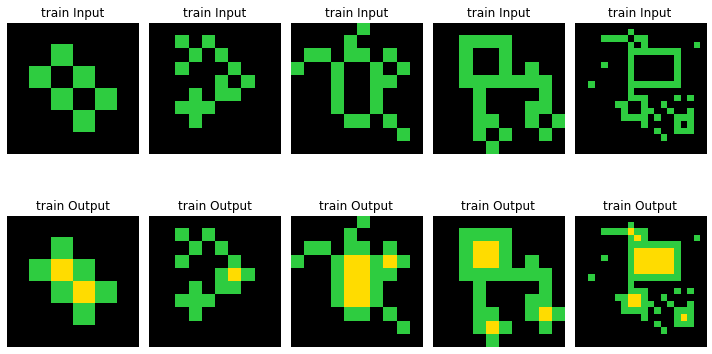

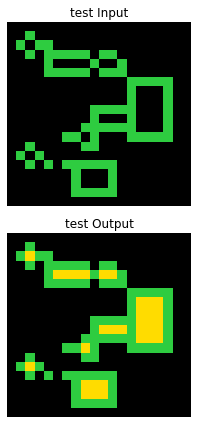

In [8]:
plot_task(train_tasks[1])

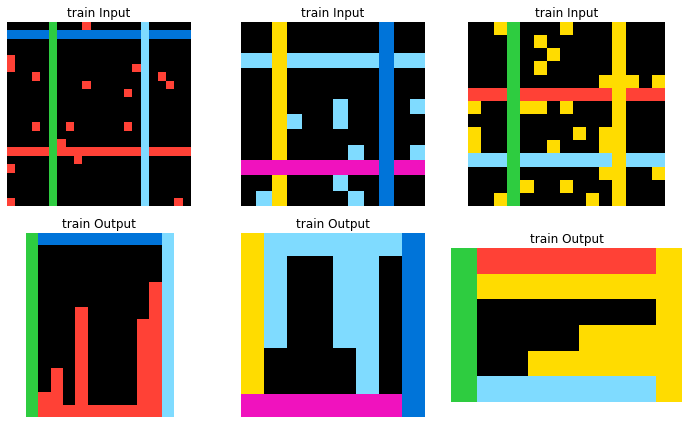

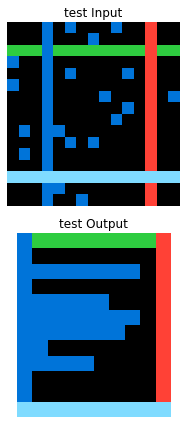

In [9]:
plot_task(train_tasks[137])

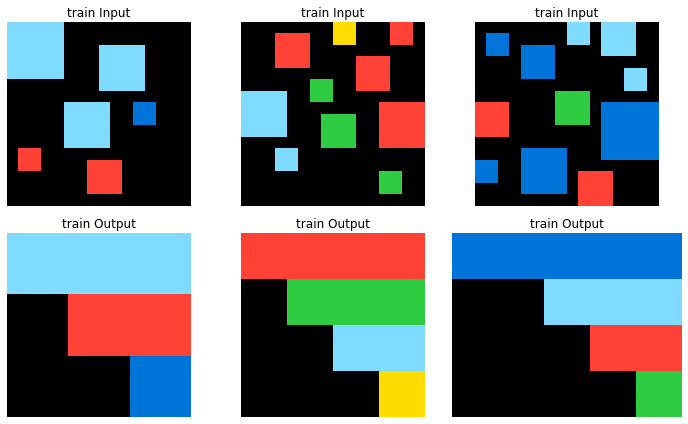

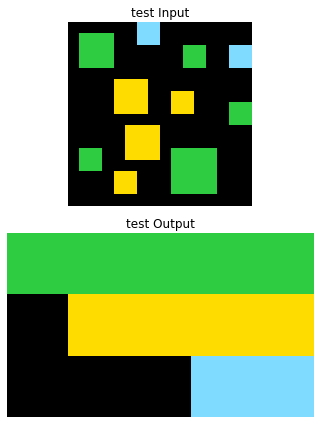

In [10]:
plot_task(val_tasks[65])

# Transform data

### View how training examples are structurized

In [11]:
train_tasks[1]['train'][0]

{'input': [[0, 0, 0, 0, 0, 0],
  [0, 0, 3, 0, 0, 0],
  [0, 3, 0, 3, 0, 0],
  [0, 0, 3, 0, 3, 0],
  [0, 0, 0, 3, 0, 0],
  [0, 0, 0, 0, 0, 0]],
 'output': [[0, 0, 0, 0, 0, 0],
  [0, 0, 3, 0, 0, 0],
  [0, 3, 4, 3, 0, 0],
  [0, 0, 3, 4, 3, 0],
  [0, 0, 0, 3, 0, 0],
  [0, 0, 0, 0, 0, 0]]}

In [0]:
def input_dim_equals_output_dim(task, isTrain):
  for example in task['train']:
    if np.array(example['input']).shape != np.array(example['output']).shape:
      return False
  if isTrain:
    for example in task['test']:
      if np.array(example['input']).shape != np.array(example['output']).shape:
        return False  
  
  return True

In [0]:
def count_equal_dims(tasks, isTrain=True):
  equal_dims = 0
  for task in tasks:
    equal_dims += input_dim_equals_output_dim(task, isTrain)
  return equal_dims

In [21]:
print("Number of equal input and output shapes in train:", count_equal_dims(train_tasks))
print("Number of equal input and output shapes in val:", count_equal_dims(val_tasks))
print("Number of equal input and output shapes in test:", count_equal_dims(test_tasks, isTrain=False))

Number of equal input and output shapes in train: 262
Number of equal input and output shapes in val: 270
Number of equal input and output shapes in test: 65


# Cellular Automata

For every problem where the input shape is equal to the output shape we can use a Cellular Automata for the transformation.

credits to [arseny-n](kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning ) for introducing cellular automata to this problem set

 and to [teddykoker](https://www.kaggle.com/teddykoker/training-cellular-automata-part-i-game-of-life) for showing a learned version of a cellular automata


#### Helper functions from teddykoker

In [0]:
def inp2img(inp):
    inp = np.array(inp)
    img = np.full((inp.shape[0], inp.shape[1], 10), 0, dtype=np.float32)
    for i in range(10):
        img[:,:,i] = (inp==i)
    return tf.expand_dims(img, 0)

def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])


def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]


# Define Model

### Currently everything below this is work in progress

In [0]:
STEPS = 50

In [0]:
class CAModel(tf.keras.layers.Layer):
  def __init__(self):
    super(CAModel, self).__init__()
    self.transition = Sequential([
        Conv2D(128, 3, padding='same', input_shape=(None, None, 10)),
        Activation('relu'),
        Conv2D(10, 1)
    ])
    
  def call(self, x, steps=1):
    for _ in range(steps):
      x = self.transition(tf.keras.activations.softmax(x, axis=1))
    return x

In [0]:
def ca_model(max_steps=10):
  model = Sequential([CAModel()])
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  return model

In [0]:
task_sample = train_tasks[1]['train'][0]
x = inp2img(task_sample['input'])

In [26]:
model = ca_model(task_sample)
model(x)

<tf.Tensor: shape=(1, 6, 6, 10), dtype=float32, numpy=
array([[[[-0.05978473, -0.00424744,  0.00274773,  0.00779328,
           0.02316993, -0.02289036,  0.06171044,  0.02619605,
           0.03781301,  0.04351518],
         [-0.07310116, -0.03449341,  0.02439341,  0.01316208,
           0.05320369, -0.05670883,  0.09695575,  0.0461618 ,
           0.02684572,  0.08223306],
         [-0.06369761, -0.04648337,  0.02259514,  0.01033731,
           0.05908274, -0.04897864,  0.09138334,  0.05569817,
           0.02887585,  0.07252704],
         [-0.07173937, -0.0384394 ,  0.02345245,  0.01185155,
           0.05293516, -0.06220925,  0.08947908,  0.05598217,
           0.01731367,  0.07252726],
         [-0.06995372, -0.03821782,  0.02954123,  0.01277312,
           0.05141533, -0.0461196 ,  0.09452569,  0.04928635,
           0.02323691,  0.06789475],
         [-0.02445023, -0.04590058,  0.07143459, -0.01539101,
           0.00620625, -0.02146358,  0.06123649,  0.02368165,
           0.029